In [1]:
import pandas_access as mdb
from datetime import datetime, timedelta

import pandas as pd
import os

import urllib

import btrdb
import uuid
from btrdb.utils import timez



In [2]:
db_path = "../data/epri_signatures/event_db.mdb"
# Listing the tables.
tables = mdb.list_tables(db_path)
print(tables)


['Events', 'SiteFeeder', 'uniq_sitefeeder', 'SiteSource', 'Site', 'Table_sitenames_ids']


In [3]:
dfs = dict(zip(tables, [mdb.read_table(db_path, tbl) for tbl in tables]))


In [4]:
dfs['Events'].head()

,id,SiteName,FeederId,EventId,Phase,First Event,Last Event,Cause,Weather,Isolation Equipment Code,Failed Equipment Code,Details
0,1,Site0006,F_0000041,3042,4,2005-01-04 03:39:06.000,2005-01-04 03:39:06.000,Equipment,Unknown,Fuse,Other,"Equipment, Device UG, Damaged."
1,2,Site0012,F_0000037,3048,3,2005-01-25 03:29:36.000,2005-01-25 03:29:51.000,Equipment,Unknown,Breaker,Capacitor,"Equipment, Capacitor Station, Damaged."
2,3,Site0006,F_0000041,3067,2,2005-02-11 06:10:46.000,2005-02-11 06:10:46.000,Weather,Wind,Breaker,No Damage,"Undetermined, Wind / Weather Related."
3,4,Site0012,F_0000037,3127,2,2005-03-22 18:33:30.000,2005-03-22 18:33:30.000,Equipment,Unknown,Fuse,Transformer,"Equipment, Transformer UG, Damaged."
4,6,Site0006,F_0000041,3152,2,2005-06-13 18:39:58.000,2005-06-13 18:39:58.000,Equipment,Unknown,Fuse,Transformer,"Equipment, Transformer UG, Damaged."


In [9]:
len(list(set([s.collection for s in db.streams_in_collection('PQdata/epri')])))

254

In [13]:
streams = db.streams_in_collection('PQdata/epri')
_streams = db.streams_in_collection(streams[0].collection)

In [19]:
from btrdb.utils.timez import ns_to_datetime
print(str(ns_to_datetime(_streams[0].latest()[0].time)-ns_to_datetime(_streams[0].earliest()[0].time)))

0:00:01.996605


In [9]:
metadata_fields = ['EventId','SiteName', 'FeederId','Phase','Cause','Weather','Isolation Equipment Code','Failed Equipment Code','Details']
metadata = dfs['Events'][metadata_fields]
metadata.head()

,EventId,SiteName,FeederId,Phase,Cause,Weather,Isolation Equipment Code,Failed Equipment Code,Details
0,3042,Site0006,F_0000041,4,Equipment,Unknown,Fuse,Other,"Equipment, Device UG, Damaged."
1,3048,Site0012,F_0000037,3,Equipment,Unknown,Breaker,Capacitor,"Equipment, Capacitor Station, Damaged."
2,3067,Site0006,F_0000041,2,Weather,Wind,Breaker,No Damage,"Undetermined, Wind / Weather Related."
3,3127,Site0012,F_0000037,2,Equipment,Unknown,Fuse,Transformer,"Equipment, Transformer UG, Damaged."
4,3152,Site0006,F_0000041,2,Equipment,Unknown,Fuse,Transformer,"Equipment, Transformer UG, Damaged."


In [29]:
def get_event_data(event_id):
    event_id = str(event_id).zfill(4)
    
    with urllib.request.urlopen('https://pqmon.epri.com/doe_folder/%s/%s.csv'%(event_id, event_id)) as response:
       out = response.read().splitlines()
    
    return out
    
def get_start_time(out):
    return datetime.strptime(out[0].decode("utf-8").split(' - ')[1], "%m/%d/%Y %H:%M:%S.%f")
    
    

In [149]:

def to_dataframe(out, row0=3):
    cols = out[2].decode("utf-8").split(', ')
    
    df = pd.DataFrame(index=range(row0,len(out)-row0), columns=cols)
    for i in df.index:
        newrow = pd.Series(out[i].decode("utf-8").split(', '), index=cols)
        df.loc[i] = newrow
        
    if len(cols) != len(list(set(cols))):
        df_list = []
        for i in range(0,len(cols),2):
            df_list.append(pd.DataFrame(array[:,i:i+2], columns=[cols[i], cols[i+1]]).set_index(cols[i]))
        df = pd.concat(df_list, axis=0, join='outer').reset_index()

        idx = df == ''
        df[idx] = np.nan
    
    df = df.astype(float)
    df['tstamp'] = (1e9*df['Time (s)'] + timez.to_nanoseconds(start)).astype(int)
    df.set_index('tstamp', inplace=True)
    df.drop('Time (s)', axis=1, inplace=True)
    return df
        

In [7]:
laurels_api_key = '2301C47D67FB1C2C48D0CC7B'
db = btrdb.connect("api.ni4ai.org:4411", apikey=laurels_api_key)

collection = 'lndunn/PQdata/epri'


In [150]:
def get_units(stream_name):
    if 'V' in stream_name:
        return 'volts'
    elif 'I' in stream_name:
        return 'amps'
    
for i, event in metadata.iterrows():
    meta = dict(zip(event.index.str.replace(' ',''), event.tolist()))
    
    event_name = str(meta['EventId']).zfill(4)
    out = get_event_data(event['EventId'])
    start = get_start_time(out)
    df = to_dataframe(out)
    
    if len(df) == 0:
        print('skipping event:', event_name)
        continue
    
    meta['EventTime'] = start.strftime('%Y-%m-%d %H:%M:%S.%f')
    meta['EventId'] = event_name
    meta['DataSource'] = 'https://pqmon.epri.com/see_all.html'
    meta['Phase'] = str(meta['Phase'])
    for key in meta.keys():
        if key.replace(' ', '') == key:
            pass
        else:
            meta[key.replace(' ', '')] = meta[key]
            
    
    for key in meta.keys():
        if pd.isnull(meta[key]):
            meta[key] = 'Unknown'
    
    tags = dict(zip(df.keys().tolist(), [{'name': key, 'unit': get_units(key)} for key in df.keys()]))
    
    streams = db.streams_in_collection(os.path.join(collection, 'event%s'%(event_name)))
    for key in df.keys():
        if key not in [s.name for s in streams]:
            s = db.create(uuid=uuid.uuid4(),
                          collection=os.path.join(collection, 'event%s'%(event_name)),
                          tags=tags[key],
                          annotations=meta)
            
            idx = pd.notnull(df[key])
            
            s.insert(df[[key,]][idx].to_records().tolist())
    


ValueError: Cannot convert non-finite values (NA or inf) to integer

In [111]:
streams = db.streams_in_collection('lndunn/PQdata/epri')


In [173]:
row0 = 3
cols = out[2].decode("utf-8").split(', ')
    
df = pd.DataFrame(index=range(row0,len(out)-row0), columns=cols)
for i in df.index:
    newrow = pd.Series(out[i].decode("utf-8").split(', '), index=cols)
    df.loc[i] = newrow

if len(cols) != len(list(set(cols))):
    df_list = []
    ts = []
    for i in range(0,len(cols),2):
        df_list.append(pd.DataFrame(array[:,i:i+2], columns=[cols[i], cols[i+1]]).set_index('Time (s)'))
        
        
#     df = pd.DataFrame(index=ts, columns=)
    df = pd.concat(df_list, axis=0, join='outer').reset_index()

    idx = df == ''
    df[idx] = np.nan

df = df.astype(float)
df['tstamp'] = (1e9*df['Time (s)'] + timez.to_nanoseconds(start)).astype(int)
df.set_index('tstamp', inplace=True)
df.drop('Time (s)', axis=1, inplace=True)

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
df_list[0].join(df_list[1:], how='outer').head()

In [143]:
import numpy as np
array = np.array(df[0])
cols = df[1]
for i in range(0,len(cols),2):
    s = pd.DataFrame(array[:,i:i+2], columns=[cols[i], cols[i+1]]).set_index(cols[i])
    print(s.head())


                                  Vab
Time (s)                             
0                      16271.97265625
0.0000651041700621136   16137.6953125
0.000130208340124227   15856.93359375
0.000195312510186341   15734.86328125
0.000260416680248454   15515.13671875
                                 Vbc
Time (s)                            
0                      -2319.3359375
0.0000651041700621136  -1977.5390625
0.000130208340124227     -1660.15625
0.000195312510186341    -1123.046875
0.000260416680248454   -817.87109375
                                   Vca
Time (s)                              
0                       -13793.9453125
0.0000651041700621136    -13916.015625
0.000130208340124227    -14184.5703125
0.000195312510186341   -14416.50390625
0.000260416680248454      -14550.78125
                                 Ia
Time (s)                           
0                      803.22265625
0.000130208340124227   817.87109375
0.000260416680248454   812.98828125
0.000390625020372681  

In [116]:
events = list(set(os.path.split(s.collection)[1] for s in streams))

In [118]:
nstreams = pd.Series(0, index=events)
for e in events:
    nstreams.loc[e] = len(db.streams_in_collection(os.path.join('lndunn/PQdata/epri', e)))

In [119]:
nstreams.head()

event21835    7
event2999     6
event2920     7
event3428     7
event2802     7
dtype: int64

In [120]:
len(nstreams)

254

<AxesSubplot:>

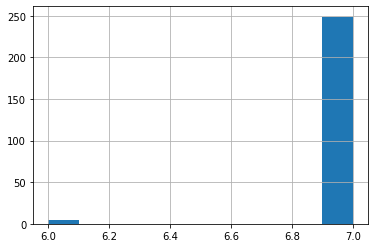

In [121]:
nstreams.hist()

In [122]:
idx = nstreams == 6
sum(idx)

5

In [123]:
nstreams[idx]

event2999    6
event2993    6
event2998    6
event2995    6
event2997    6
dtype: int64